# 1. Προετοιμασία δεδομένων

#### 1.0 Import τα απατούμενα packages της Python

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import json

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import resample
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from tqdm.notebook import tqdm

from collections import Counter

from neural_network_classifier import OscarClassificationNeuralNetwork, accuracy_fn

from plotting_functions import plot_roc_curves, plot_classification_reports_averages, plot_confusion_matrices
from utils import build_resampled_datasets, best_f1_score_for_each_sampling_method

# from google.colab import drive
# drive.mount('/content/drive')
import pickle

# 5. Μοντέλα προβλέψεων - τεχνικές αντιμετώπισης ανισόρροπων δεδομένων

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/#h-3-smote

Pipeline

PCA -> Sampling methods -> training with gridsearch cv parameter searching -> classification on unknown dataset with best achieved (or specific upsampling like SMOTE) f1 score parameters -> final decission >=4

In [2]:
# df_un_cl.to_csv('./cleaned_dataframe_unknown.csv', index=False)
# df_cl.to_csv('./cleaned_dataframe_train.csv', index=False)

In [3]:
df_un_cl = pd.read_csv('./cleaned_dataframe_unknown.csv')
df_cl = pd.read_csv('./cleaned_dataframe_train.csv')
df_cl = df_cl.drop(['PC1', 'PC2', 'kmeans_pca', 'kmeans', 'kmeans_audience', 'dbscan', 'agg'], axis=1)
df_un_orig = pd.read_excel('movies_test_anon.xlsx')

In [4]:
len(df_cl.columns)

62

In [5]:
model_results = {}

## Feature selection with PCA

### Training Dataset

In [6]:
df_cl.columns

Index(['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama',
       'st_sequel', 'st_semi-sequel', 'st_remake', 'st_original screenplay',
       'st_documentary', 'st_reboot', 'st_based on a true story',
       'st_adaptation', 'st_prequel', 'film', 'year',
       'rotten_tomatoes_critics', 'metacritic_critics', 'average_critics',
       'rotten_tomatoes_audience', 'metacritic_audience',
       'rotten_tomatoes_vs_metacritic_deviance', 'average_audience',
       'audience_vs_critics_deviance', 'opening_weekend',
       'opening_weekend_($million)', 'domestic_gross',
       'domestic_gross_($million)', 'foreign_gross_($million)',
  

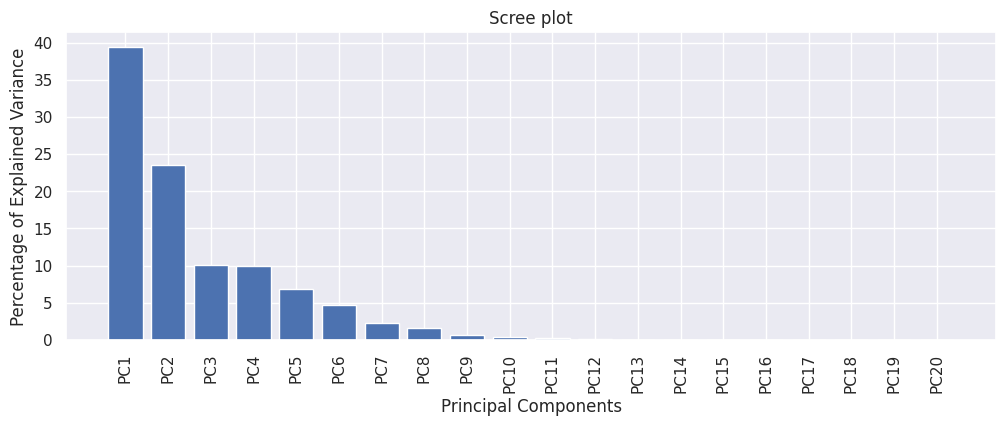

In [7]:
x = df_cl.drop(['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama',
       'st_sequel', 'st_semi-sequel', 'st_remake', 'st_original screenplay',
       'st_documentary', 'st_reboot', 'st_based on a true story',
       'st_adaptation', 'st_prequel','film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

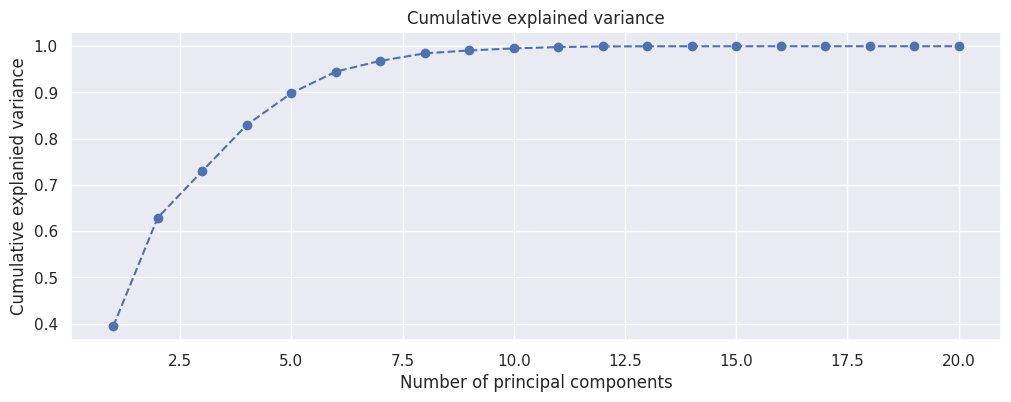

In [8]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

In [9]:
# Calculate PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

### Unknown dataset

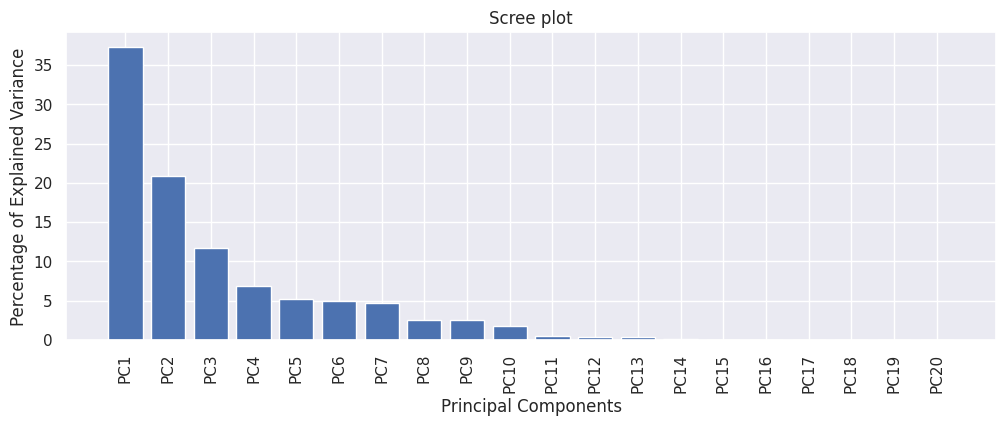

In [10]:
# x = df_un_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)
x = df_un_cl.drop(['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama',
       'st_sequel', 'st_semi-sequel', 'st_remake', 'st_original screenplay',
       'st_documentary', 'st_reboot', 'st_based on a true story',
       'st_adaptation', 'st_prequel','film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

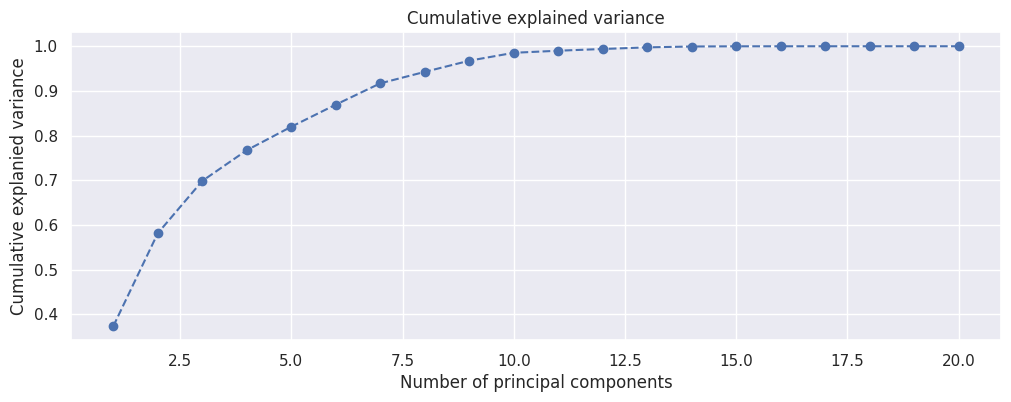

In [11]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

In [12]:
# Calculate PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_un_cl = pd.concat([df_un_cl, principal_components_df], axis=1)

## ADA Boost

In [13]:
# df = df_cl.drop(['film','year', 'distributor','imdb_rating','imdb_vs_rt_disparity','release_date_(us)',
#                     'oscar_detail', 'PC1', 'PC2',
#        'kmeans_pca', 'kmeans', 'kmeans_audience', 'dbscan', 'agg'], axis=1)

# Select PCA components
df = df_cl[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'oscar_winners']]

# Use most correlated features

# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience', 'gen_history',
#        'domestic_gross_($million)','gen_biography','worldwide_gross_($million)','oscar_winners']]

train_datasets, test_dataset = build_resampled_datasets(df, test_ratio=0.3)

In [14]:
results = {}

In [15]:
#Ada boost
results['ADA'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['ADA'][sampling] = []

    model = AdaBoostClassifier(random_state=1)
    parameters = {'n_estimators': range(10, 1001, 10),
                }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['ADA'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters for default: {'n_estimators': 100}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for upsampled: {'n_estimators': 860}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for downsampled: {'n_estimators': 190}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for SMOTE: {'n_estimators': 90}


In [16]:
params= {}
for sampling in results['ADA']:
    params[sampling] = results['ADA'][sampling][0]['params'] 

with open("./ADA.json", 'w') as f:
    json.dump(params, f)    

## Gradient Boost

In [17]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'opening_weekend_($million)', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

# train_datasets, test_dataset = build_resampled_datasets(df)

In [18]:
# Gradient boosting classifier

results['GRB'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['GRB'][sampling] = []

    model = GradientBoostingClassifier(random_state=1)

    # parameters = {
    #     # "min_samples_split": [500],
    #     # "min_samples_leaf": [10],
    #     # "max_depth": range(1,11,2),
    #     # "max_features":["sqrt"],
    #     # "criterion": ["friedman_mse",  "mae"],
    #     # "subsample":[0.8],
    #     # 'n_estimators':range(1, 201, 2),
    #     'n_estimators' : range(10, 1001, 10),
    #     "learning_rate": [0.01, 0.1, 0.4, 0.8],
    #     "max_depth": range(1, 6, 1)
    # }

    parameters = {
        "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
        "min_samples_split": np.linspace(0.1, 0.5, 12),
        "min_samples_leaf": np.linspace(0.1, 0.5, 12),
        "max_depth":[3,5,8],
        "max_features":["log2","sqrt"],
        "criterion": ["friedman_mse",  "squared_error"],
        "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
        "n_estimators":[10]
    }

    # parameters = {
    #     "learning_rate": [x/100 for x in range(1, 11, 1)],
    #     'n_estimators' : range(10, 501, 10),
    #     'subsample' :  [x/100 for x in range(1, 11, 1)],
    #     'min_weight_fraction_leaf' : [x/100 for x in range(1, 6, 1)],        
    #     "max_depth": range(1, 11, 1)
    # }


    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['GRB'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 84672 candidates, totalling 423360 fits
Best parameters for default: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 0.9}
Fitting 5 folds for each of 84672 candidates, totalling 423360 fits
Best parameters for upsampled: {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.24545454545454548, 'n_estimators': 10, 'subsample': 1.0}
Fitting 5 folds for each of 84672 candidates, totalling 423360 fits
Best parameters for downsampled: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 0.95}
Fitting 5 folds for each of 84672 candidates, totalling 423360 fits
Best parameters for SMOTE: {'criterion': 'friedman_mse', 'learning_rate': 0

In [19]:
params= {}
for sampling in results['GRB']:
    params[sampling] = results['GRB'][sampling][0]['params'] 

with open("./GRB.json", 'w') as f:
    json.dump(params, f)    

## Decision Tree

In [20]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'opening_weekend_($million)', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'budget_($million)', 'oscar_winners']]

# train_datasets, test_dataset = build_resampled_datasets(df)

In [21]:
# Decision tree classifier
results['DT'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['DT'][sampling] = []

    model = DecisionTreeClassifier(random_state=1)

    # parameters = {
    #     "criterion": ['gini', 'entropy', 'log_loss'],
    #     "splitter": ['best', 'random'],
    #     "max_depth": range(2,11,2),
    # }

    parameters = {
        "criterion": ['gini', 'entropy'],
        "splitter": ['best', 'random'],
        "max_depth": range(1, 11, 1),
        'min_samples_split' : range(2, 11, 1),
        'min_samples_leaf' : range(1, 6, 1),
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['DT'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Best parameters for default: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'splitter': 'random'}
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Best parameters for upsampled: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Best parameters for downsampled: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'random'}
Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Best parameters for SMOTE: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [22]:
params= {}
for sampling in results['DT']:
    params[sampling] = results['DT'][sampling][0]['params'] 

with open("./DT.json", 'w') as f:
    json.dump(params, f)   

## Random Forest

In [23]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'oscar_winners']]

# df = df_cl[['PC1', 'PC2', 'oscar_winners']]

# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'oscar_winners']]

# train_datasets, test_dataset = build_resampled_datasets(df)

In [24]:
# Random forest
# model = RandomForestClassifier()
# Decision tree classifier
results['RF'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['RF'][sampling] = []

    model = RandomForestClassifier(n_jobs=-1, random_state=1)

    # parameters = {
    #     'max_depth':[3,5,10,None],
    #           'n_estimators':[10,100,200],
    #           'max_features':[1,3,5,7],
    #         #   'min_samples_leaf':[1,2,3],
    #         #   'min_samples_split':[1,2,3]      
  
    # }

    parameters = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['log2', 'sqrt', None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['RF'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 5940 candidates, totalling 29700 fits


KeyboardInterrupt: 

In [ ]:
params= {}
for sampling in results['RF']:
    params[sampling] = results['RF'][sampling][0]['params'] 

with open("./RF.json", 'w') as f:
    json.dump(params, f)   

## K-Nearest Neighbors

Select features

In [ ]:
# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience',
#        'oscar_winners']]

# df = df_cl[['PC1', 'PC2', 'oscar_winners']]

# df = df_cl[['rotten_tomatoes_critics', 'metacritic_critics',
#        'rotten_tomatoes_audience', 'metacritic_audience', 'domestic_gross_($million)',
#        'foreign_gross_($million)', 'oscar_winners']]

# train_datasets, test_dataset = build_resampled_datasets(df)

Train and test

In [ ]:
# Random forest
# model = RandomForestClassifier()
# Decision tree classifier
results['KNN'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['KNN'][sampling] = []

    model = KNeighborsClassifier(n_jobs=-1)

    # parameters = {
    #     "n_neighbors": range(2, 21),
    #     "weights": ['uniform', 'distance'],
    #     "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # }

    parameters = {
        "n_neighbors": range(2, 21),
        "weights": ['uniform', 'distance'],
        "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size' : range(1, 201, 10)
    }


    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['KNN'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

    

Fitting 5 folds for each of 3040 candidates, totalling 15200 fits
Best parameters for default: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'weights': 'distance'}
Fitting 5 folds for each of 3040 candidates, totalling 15200 fits
Best parameters for upsampled: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'weights': 'uniform'}
Fitting 5 folds for each of 3040 candidates, totalling 15200 fits
Best parameters for downsampled: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 6, 'weights': 'uniform'}
Fitting 5 folds for each of 3040 candidates, totalling 15200 fits
Best parameters for SMOTE: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 2, 'weights': 'distance'}


In [ ]:
params= {}
for sampling in results['KNN']:
    params[sampling] = results['KNN'][sampling][0]['params'] 

with open("./KNN.json", 'w') as f:
    json.dump(params, f)    

## Plot results

Classification reports

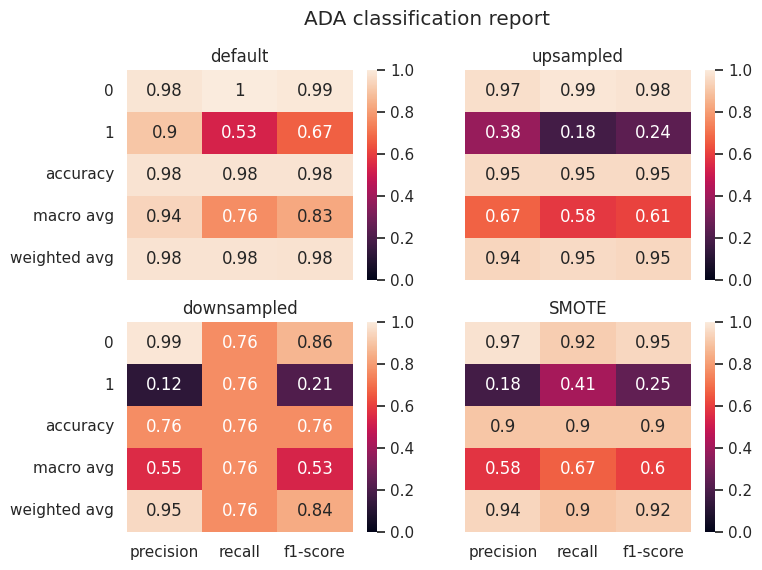

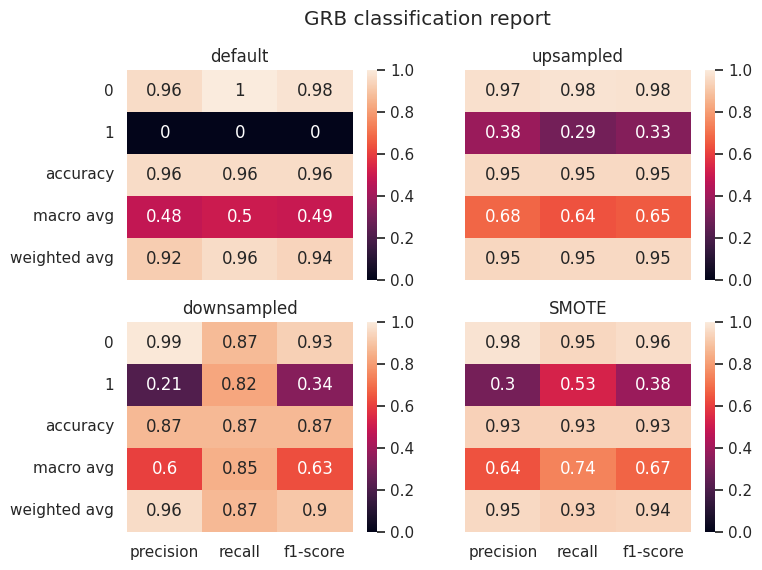

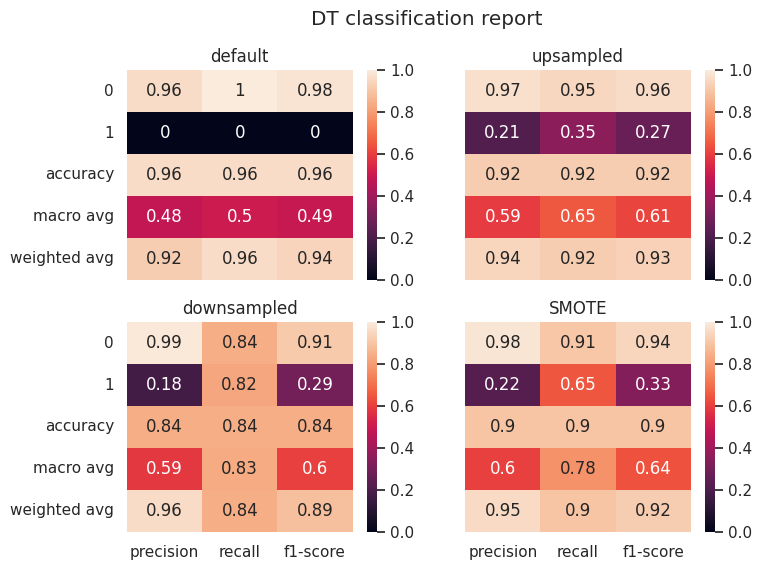

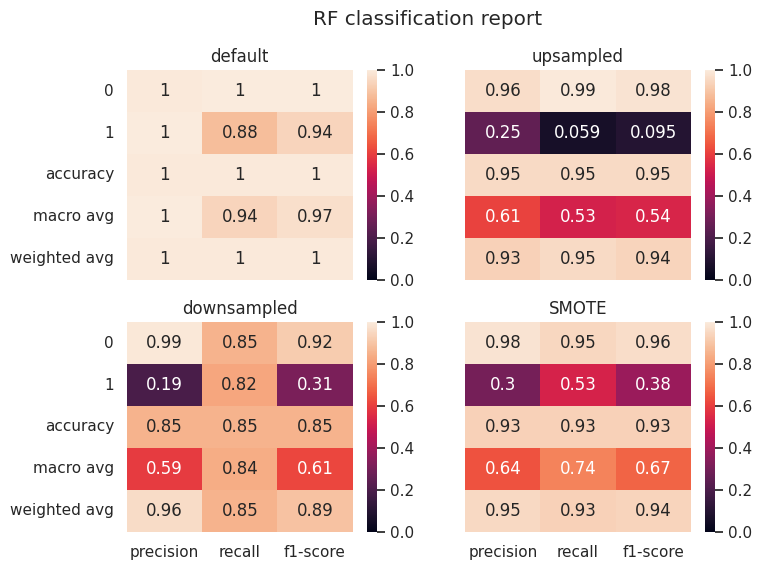

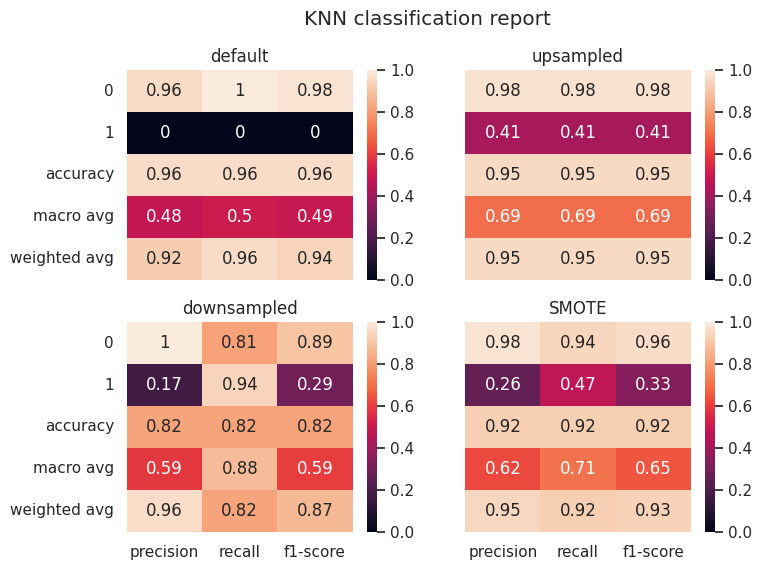

In [ ]:
plot_classification_reports_averages(results, 'ADA')
plot_classification_reports_averages(results, 'GRB')
plot_classification_reports_averages(results, 'DT')
plot_classification_reports_averages(results, 'RF')
plot_classification_reports_averages(results, 'KNN')

ROC Curves

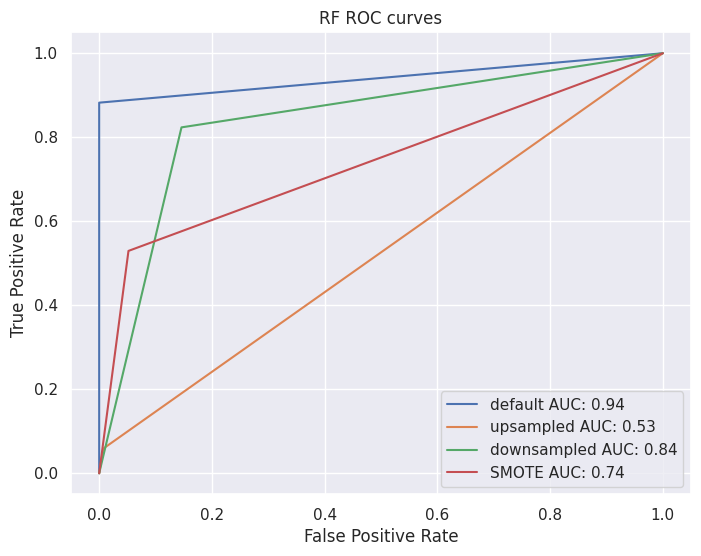

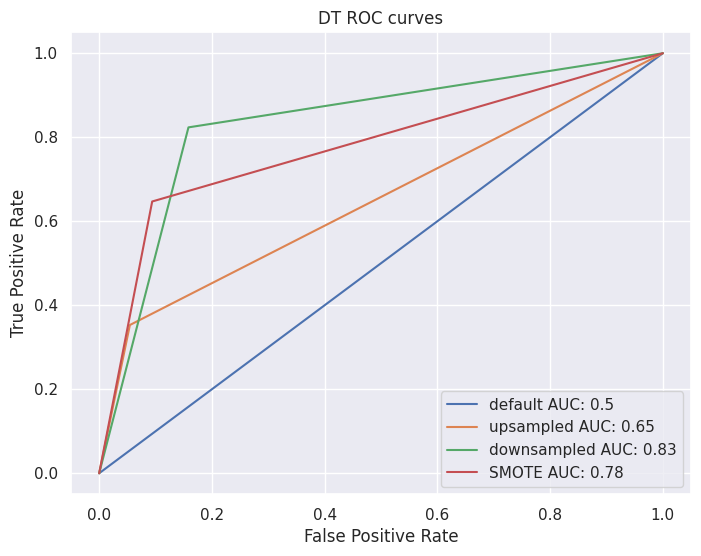

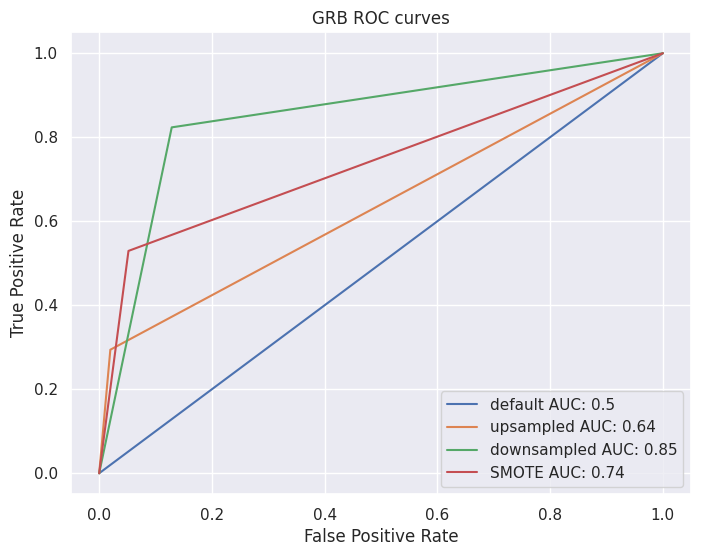

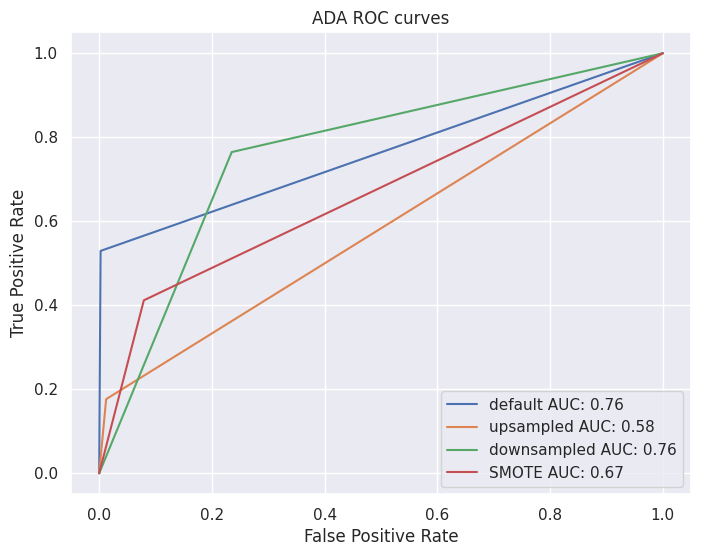

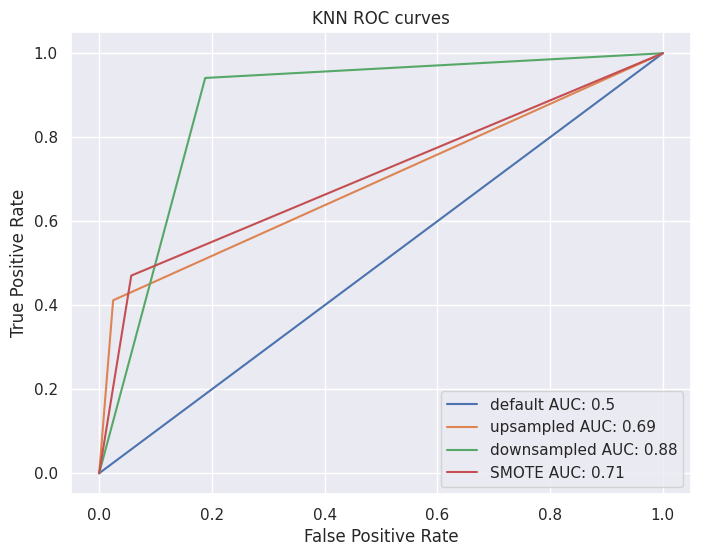

In [ ]:
best_f1_ada = best_f1_score_for_each_sampling_method(results, 'ADA')
best_f1_grb = best_f1_score_for_each_sampling_method(results, 'GRB')
best_f1_dt = best_f1_score_for_each_sampling_method(results, 'DT')
best_f1_rf = best_f1_score_for_each_sampling_method(results, 'RF')
best_f1_knn = best_f1_score_for_each_sampling_method(results, 'KNN')
plot_roc_curves(best_f1_rf, 'RF')
plot_roc_curves(best_f1_dt, 'DT')
plot_roc_curves(best_f1_grb, 'GRB')
plot_roc_curves(best_f1_ada, 'ADA')
plot_roc_curves(best_f1_knn, 'KNN')

Confusion Matrices

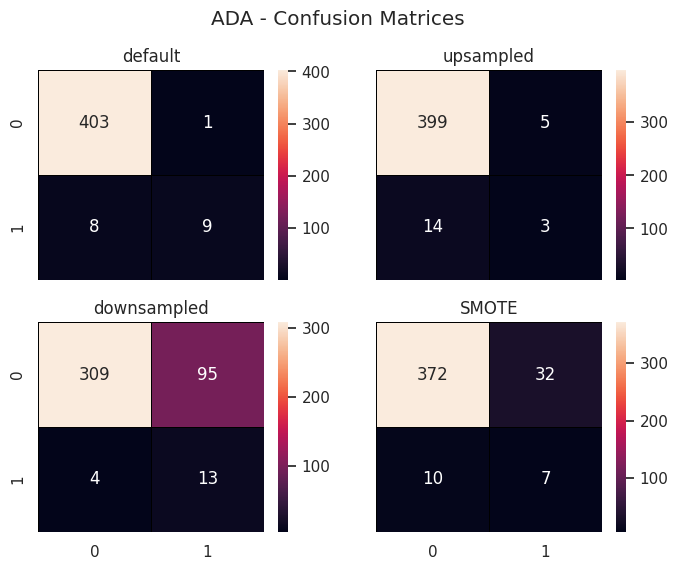

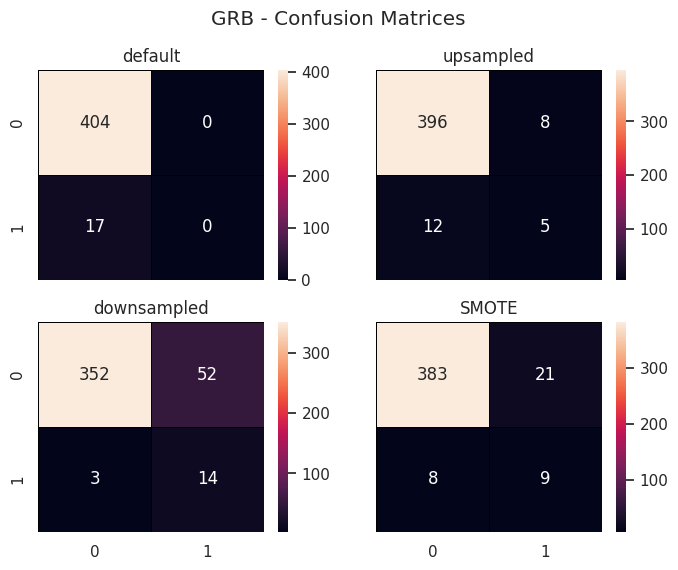

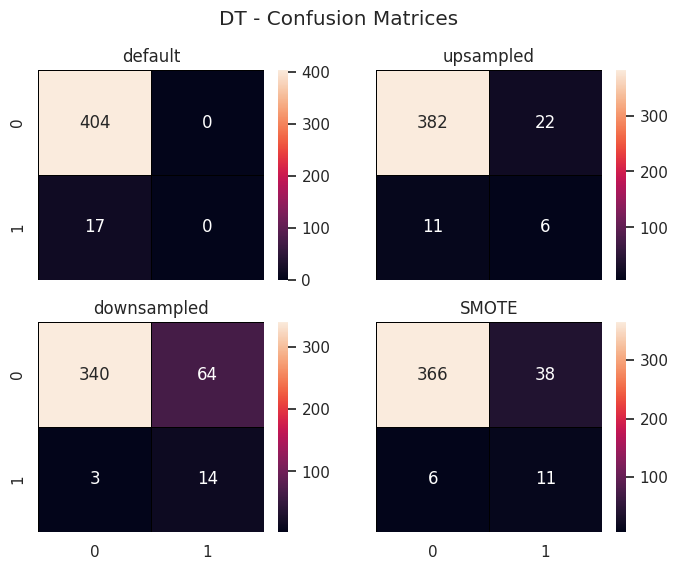

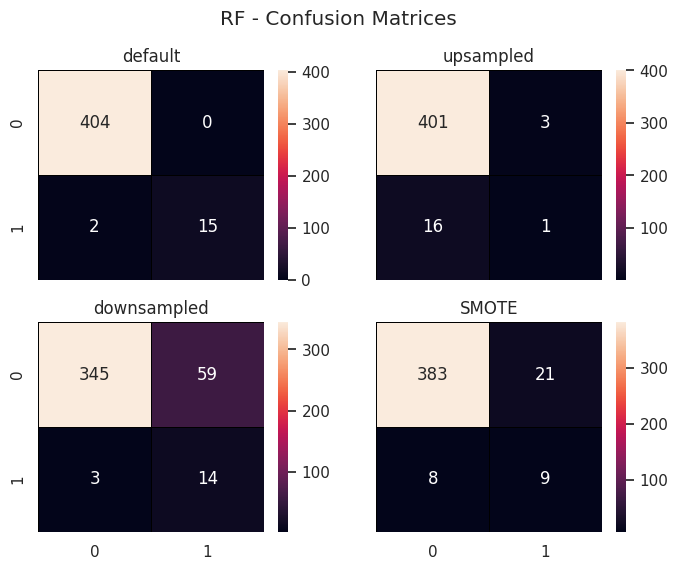

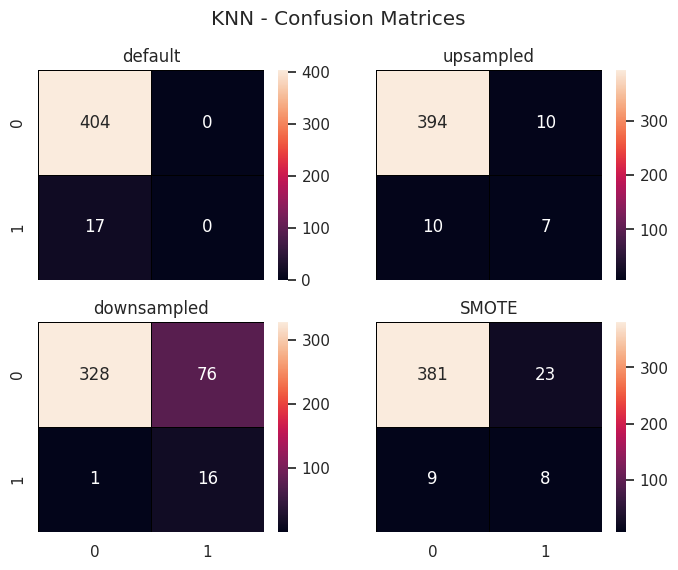

In [ ]:
plot_confusion_matrices(best_f1_ada, 'ADA')
plot_confusion_matrices(best_f1_grb, 'GRB')
plot_confusion_matrices(best_f1_dt, 'DT')
plot_confusion_matrices(best_f1_rf, 'RF')
plot_confusion_matrices(best_f1_knn, 'KNN')

# 6. Predictions on unknown dataset

#### Select unknown dataset features

In [ ]:
df_un_cl_predictions = df_cl[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]
X = df_un_cl_predictions

### 6.1 ADA Boost

In [ ]:
best_overall_ada = max(best_f1_ada.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_ada['params']
# params = results['ADA']['SMOTE'][0]['params']
# params = results['ADA']['default'][0]['params']

In [ ]:
model = AdaBoostClassifier(**params)

model.fit(best_overall_ada['X_train'], best_overall_ada['y_train'])
un_preds = model.predict(X)

df_un_orig[f'ADA'] = pd.DataFrame(un_preds)
ada_n_predicted_oscars = len(df_un_orig[df_un_orig['ADA'] == 1])
ada_n_predicted_oscars

15

### 6.2 Gradient Boost

In [ ]:
best_overall_grb = max(best_f1_grb.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_grb['params']
# params = results['GRB']['SMOTE'][0]['params']
# params = results['GRB']['default'][0]['params']
params

{'max_depth': 5, 'n_estimators': 200}

In [ ]:
# best_overall_grb = max(best_f1_grb.values(), key=lambda a:a['report']['1']['f1-score'])

model = GradientBoostingClassifier(**params)

model.fit(best_overall_ada['X_train'], best_overall_ada['y_train'])
un_preds = model.predict(X)

df_un_orig[f'GRB'] = pd.DataFrame(un_preds)
grb_n_predicted_oscars= len(df_un_orig[df_un_orig['GRB'] == 1])
grb_n_predicted_oscars

22

### 6.3 Decision Tree

In [ ]:
best_overall_dt = max(best_f1_dt.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_dt['params']
# params = results['DT']['SMOTE'][0]['params']
# params = results['DT']['default'][0]['params']
params

{'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}

In [ ]:
best_overall_dt = max(best_f1_dt.values(), key=lambda a:a['report']['1']['f1-score'])

model = DecisionTreeClassifier(**params)

# model = DecisionTreeClassifier(criterion=params['criterion'], max_depth = params['max_depth'], )

model.fit(best_overall_dt['X_train'], best_overall_dt['y_train'])
un_preds = model.predict(X)

df_un_orig[f'DT'] = pd.DataFrame(un_preds)
dt_n_predicted_oscars = len(df_un_orig[df_un_orig['DT'] == 1])
dt_n_predicted_oscars

51

### 6.4 Random Forest

In [ ]:
best_overall_rf = max(best_f1_rf.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_rf['params']
# params = results['RF']['SMOTE'][0]['params']
# params = results['RF']['default'][0]['params']
params

{'max_depth': 10, 'max_features': 3, 'n_estimators': 10}

In [ ]:
model = RandomForestClassifier(**params)

model.fit(best_overall_rf['X_train'], best_overall_rf['y_train'])
un_preds = model.predict(X)

df_un_orig[f'RF'] = pd.DataFrame(un_preds)
rf_n_predicted_oscars = len(df_un_orig[df_un_orig['RF'] == 1])
rf_n_predicted_oscars

19

### 6.5 K-Nearest Neighbors

In [ ]:
best_overall_knn = max(best_f1_knn.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_knn['params']
# params = results['KNN']['SMOTE'][0]['params']
# params = results['KNN']['default'][0]['params']
params

{'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'uniform'}

In [ ]:
model = KNeighborsClassifier(**params)
model.fit(best_overall_knn['X_train'], best_overall_knn['y_train'])

un_preds = model.predict(X)
preds_df = pd.DataFrame(un_preds)
df_un_orig[f'KNN'] = preds_df

knn_n_predicted_oscars = len(df_un_orig[df_un_orig['KNN'] == 1])
knn_n_predicted_oscars

20

## Show all model predictons

In [ ]:
#['ADA', 'GRB', 'DT','RF', 'KNN']
n_oscar_preds = pd.DataFrame([[ada_n_predicted_oscars, grb_n_predicted_oscars, dt_n_predicted_oscars, rf_n_predicted_oscars, knn_n_predicted_oscars]], columns=['ADA', 'GRB', 'DT','RF', 'KNN'])

Number of predictions per model

In [ ]:
n_oscar_preds

,ADA,GRB,DT,RF,KNN
0,15,22,51,19,20


Detailed predictions view

In [ ]:
df_un_orig[(df_un_orig['ADA'] == 1) | (df_un_orig['GRB'] == 1) | (df_un_orig['DT'] == 1) | (df_un_orig['RF'] == 1) | (df_un_orig['KNN'] == 1)][['ID','ADA', 'GRB', 'DT','RF', 'KNN']]

,ID,ADA,GRB,DT,RF,KNN
6,7,0,0,1,0,0
7,8,0,0,1,0,0
14,15,0,0,1,0,0
21,22,0,0,1,0,0
30,31,1,1,1,1,1
31,32,0,0,1,0,0
36,37,1,1,1,0,1
43,44,1,1,1,1,1
51,52,1,1,1,1,1
57,58,0,0,1,0,0


Select final oscar prediction criteria

In [ ]:
DECISION_THRESHOLD = 4

predictions = df_un_orig[['ID', 'ADA', 'GRB', 'DT','RF', 'KNN']]
predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)

/tmp/ipykernel_102801/685585381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)


Overall oscar prediction number

In [ ]:
predictions[predictions['OSCAR'] == 1]

,ID,ADA,GRB,DT,RF,KNN,OSCAR
30,31,1,1,1,1,1,1
36,37,1,1,1,0,1,1
43,44,1,1,1,1,1,1
51,52,1,1,1,1,1,1
63,64,0,1,1,1,1,1
69,70,0,1,1,1,1,1
79,80,1,1,1,1,1,1
90,91,1,1,1,1,1,1
92,93,1,1,1,1,0,1
237,238,1,1,1,1,1,1


In [ ]:
len(predictions[predictions['OSCAR'] == 1])

19

In [ ]:
print(f"Unkn dataset predicted oscar ratio: {len(predictions[predictions['OSCAR'] == 1]) / len(predictions) * 100:.2f}% | Testing dataset oscar prediction ratio: {len(df_cl[df_cl['oscar_winners'] == 1]) / len(df_cl) * 100:.2f}%")

Unkn dataset predicted oscar ratio: 3.36% | Testing dataset oscar prediction ratio: 3.99%


In [ ]:
# Save file
# predictions.to_csv('./predictions_smote.csv', index=False)

In [ ]:
old = pd.read_csv('./predictions_old.csv')